# Twitter Sentiment Analysis - Recurrent Neural Networks 
## <div> Vassilis Panagakis </div>

In [1]:
!pip install d2l==0.15.0

     |████████████████████████████████| 61kB 6.0MB/s 


In [2]:
import pandas as pd
import numpy as np 
import re
import warnings
import torch
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings('ignore')  

## Load Data

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Create a dataframe from SentimentTweets.csv file data

In [4]:
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/SentimentTweets.csv', usecols=['target','id','date','flag','user','text'])

df.head()


,target,id,date,flag,user,text
0,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [5]:
df.drop(columns=['id', 'date', 'flag', 'user'], axis=1, inplace=True) #drop useless columns

df.head()

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,4,A @ 415 B @ 425. Tell your bro i say congrats!
3,4,@littlefluffycat Indeed.
4,4,Completed Race 4 Life in 58mins with girlies f...


In [6]:
# split 'target' and 'text' columns 
X = df[['text']]
y = df[['target']]

In [7]:
from sklearn.model_selection import train_test_split

# get train and test dataframes 
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, stratify=df['target'], random_state = 42)

#### Display train and test sets after split

In [8]:
train_X.head()

,text
492660,The respected journalist @robfahey just tried ...
858754,"@maggienash Thanks, Maggie. I'm still bouncing"
746070,"@do0dlebugdebz not now,but will be if you're o..."
885531,@Pure798 yea that works...ughh
806384,@melapoo lol Cool. I keep getting the weird on...


In [9]:
test_X.head()

,text
220479,...... fuck you soderling. fuck you. this has ...
840623,OK next step - today I learn to twitter from m...
772674,trying to upload a picture and loves how twitt...
1037193,@addictedtonye Get 100 followers a day using w...
971656,@AmeliaBt It sure is..


## Labels Pre-processing

In [10]:
# replace 4 with 1 to create binary labels
train_Y = train_Y.replace(4,1)
test_Y = test_Y.replace(4,1)

# create numpy arrays for sets' labels
train_y = np.asarray(train_Y['target'].tolist()) 
test_y = np.asarray(test_Y['target'].tolist())

# covert numpy arrays to torch tensors
train_y, test_y = map(torch.tensor, (train_y, test_y))
# covert tensors data to float
train_y, test_y = train_y.float(), test_y.float()

## Data Pre-processing

#### Load cleansed data from csv


In [ ]:
# restore processed data
train_X = pd.read_csv('gdrive/My Drive/Colab Notebooks/CleanedTrain.csv', usecols=['text','processedText'])
test_X = pd.read_csv('gdrive/My Drive/Colab Notebooks/CleanedTest.csv', usecols=['text','processedText'])

### Cleanse data

In [11]:
# function that removes all @mentions, links and non alphabetic strings 
def clean_content(text):
    
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # remove text with @ prefix
    text = re.sub(r'http\S+', '', text) # remove text with http prefix (links)  
    text = re.sub(r'www\S+', '', text) # remove text with www prefix (links)
    text = re.sub(r'\\\w+', '', str(text)) # remove text after backslash
    text = re.sub(r'\b\w{1,2}\b', '', text) # remove text containing 2 or less characters
    
    text =  ''.join(ch for ch in text if ch.isalpha() or ch == ' ')
    
    text = text.lower() # convert text into lowercase
    
    return text

In [12]:
# create a column for each set containing the processed text data
for index, row in train_X.iterrows():
    train_X.loc[index,'processedText'] = clean_content(train_X.loc[index,'text'])

for index, row in test_X.iterrows():
    test_X.loc[index,'processedText'] = clean_content(test_X.loc[index,'text'])

#### Display train and test sets after text cleansing

In [13]:
train_X.head()

,text,processedText
492660,The respected journalist @robfahey just tried ...,the respected journalist just tried have sex...
858754,"@maggienash Thanks, Maggie. I'm still bouncing",thanks maggie still bouncing
746070,"@do0dlebugdebz not now,but will be if you're o...",not nowbut will you just sounded like da...
885531,@Pure798 yea that works...ughh,yea that worksughh
806384,@melapoo lol Cool. I keep getting the weird on...,lol cool keep getting the weird ones got th...


In [14]:
test_X.head()

,text,processedText
220479,...... fuck you soderling. fuck you. this has ...,fuck you soderling fuck you this has night...
840623,OK next step - today I learn to twitter from m...,next step today learn twitter from phone ...
772674,trying to upload a picture and loves how twitt...,trying upload picture and loves how twitter ...
1037193,@addictedtonye Get 100 followers a day using w...,get followers day using once you add every...
971656,@AmeliaBt It sure is..,sure


In [ ]:
# # store processed data to a csv file
# train_X.to_csv('gdrive/My Drive/Colab Notebooks/CleanedTrain.csv', index = True, header=True)
# test_X.to_csv('gdrive/My Drive/Colab Notebooks/CleanedTest.csv', index = True, header=True)

### Tf-idf Vectorization

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(max_df=0.99, min_df=1, stop_words='english', max_features=50)

# apply tf-idf transformation to both train and test sets data
tr_tfidf = tfidfVectorizer.fit_transform(train_X['processedText'])
te_tfidf = tfidfVectorizer.transform(test_X['processedText'])

# insert transformed data to numpy arrays for both training and test sets
train_tfidf = tr_tfidf.toarray()
test_tfidf = te_tfidf.toarray()

#### Convert input vectors to torch tensors

In [16]:
# covert numpy arrays to torch tensors
train_tfidf, test_tfidf = map(torch.tensor, (train_tfidf, test_tfidf))
# covert tensors data to float
train_tfidf, test_tfidf = train_tfidf.float(), test_tfidf.float()

### GloVe Pre-trained Embeddings

In [17]:
from torchtext.data import Field 
from torchtext.vocab import GloVe

#### Load glove embeddings from disk

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/train_glove.pkl', 'rb') as fp:
    train_glove = pickle.load(fp)

with open('gdrive/My Drive/Colab Notebooks/test_glove.pkl', 'rb') as fp:
    test_glove = pickle.load(fp)

In [ ]:
padding = train_X.processedText.map(lambda x: len(x)).max() # find the largest 'processedText' in dataframe to determine the padding's length

#### Convert input vectors to torch tensors

In [ ]:
#covert numpy arrays to torch tensors
train_glove, test_glove = map(torch.tensor, (train_glove, test_glove))
# covert tensors data to float
train_glove, test_glove = train_glove.float(), test_glove.float()

### Produce embedding input vectors

In [18]:
emb_size=50

embedding = GloVe(name='6B', dim=emb_size) # use "glove.6B.50d" as embedding

.vector_cache/glove.6B.zip: 862MB [06:52, 2.09MB/s]                           
100%|█████████▉| 399838/400000 [00:10<00:00, 36397.69it/s]

In [19]:
# function to tokenize preprocessed text and add the necessary padding tokens 
def tokenize(df, padding):

  text_field = Field(
      sequential=True,
      tokenize='spacy', 
      fix_length=padding,
      lower=True
  )

  label_field = Field(sequential=False, use_vocab=False)

  preprocessed_text = df['processedText'].apply(
      lambda x: text_field.preprocess(x)
  )

  return preprocessed_text

In [20]:
# function that creates a mean vector for a series of tokens
def tokens_to_vector(tokens, embedding, emb_size):
  vectors = []
  
  for token in tokens:
    try: 
        vectors.append(embedding[token].cpu().detach().numpy()) # add word's vector to list if word belongs to embedding dictionary
    except KeyError:
        vectors.append(np.zeros(emb_size).astype('float32') ) # else, add a zero vector to the list to represent unknown words
          
  total = np.zeros(emb_size).astype('float32') 
  
  # compute the mean vector
  for v in vectors: 
      total += v
      
  mean = total / len(vectors)

  return mean.tolist() # return vector in list format

In [21]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [22]:
padding = train_X.processedText.map(lambda x: len(x)).max() # find the largest 'processedText' in dataframe to determine the padding's length

In [23]:
# apply tokenization to both train and test sets
train_toks = tokenize(train_X, padding)
test_toks = tokenize(test_X, padding)

100%|█████████▉| 399838/400000 [00:30<00:00, 36397.69it/s]

In [24]:
tr_glove = [] 

# create a list of vectors for every series of tokens in train set
for i, tokens in enumerate(train_toks):
  tr_glove.append(tokens_to_vector(tokens, embedding, emb_size))

te_glove = []

# create a list of vectors for every series of tokens in test set
for i, tokens in enumerate(test_toks):
  te_glove.append(tokens_to_vector(tokens, embedding, emb_size))

In [25]:
# convert list of vectors to numpy array
train_glove = np.array(tr_glove)
test_glove = np.array(te_glove)

In [ ]:
# # store glove embeddings to disk
# with open('gdrive/My Drive/Colab Notebooks/train_glove.pkl', 'wb') as fp:
#     pickle.dump(train_glove, fp)

# with open('gdrive/My Drive/Colab Notebooks/test_glove.pkl', 'wb') as fp:
#     pickle.dump(test_glove, fp)

#### Convert input vectors to torch tensors

In [26]:
#covert numpy arrays to torch tensors
train_glove, test_glove = map(torch.tensor, (train_glove, test_glove))
# covert tensors data to float
train_glove, test_glove = train_glove.float(), test_glove.float()

## Recurrent Neural Networks

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

### Evaluation Functions

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from d2l import torch as d2l

# function that creates a dataframe to display the Precision, Recall and F1-score of the Neural Networks
def display_metrics(model):
  nn_dic = {model:['-','-','-']}
  nn_df = pd.DataFrame.from_dict(nn_dic, orient='index', columns=['Precision','Recall','F1-Score'])

  return nn_df

# function to plot loss per epoch
def loss_per_epoch(loss, title):
  plt.figure(figsize=(8, 5))
  plt.style.use('seaborn-whitegrid')

  plt.plot(range(len(loss)), loss)
  plt.title('Loss - Epoch Diagram (' + title + ')', size=20)
  plt.xlim=[1, len(loss)]
  plt.xlabel('Epochs', size=20)

  plt.yticks(loss, [i for i in loss])
  plt.yscale('logit')
  plt.ylabel('Loss', size=20)

  plt.show()

 
# function that plots the ROC curve on the test set
def roc_plot(net, test_X, test_y, batch_size, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  test_iter = d2l.load_array((test_X, test_y), batch_size) # split train set in batches
  
  fin_y_pred = []
  prec, rec, f1 = 0, 0, 0
  for X, y in test_iter:
    dim = X.shape[1]
    X = X.unsqueeze(1)
    X = X.expand(X.shape[0], dim, dim)
    
    # add parameters to device
    X = X.to(device)
    y = y.to(device)

    y_pred = net.predict(X) # execute predict on test set
    y_pred = torch.mean(y_pred, dim=1) # calculate mean
    y_pred = y_pred.cpu().data.numpy() # convert to numpy

    y = y.cpu().data.numpy() # convert to numpy 

    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(8, 5))
  plt.style.use('seaborn-whitegrid')
  plt.plot(fpr[1], tpr[1])

  plt.title('Receiver operating characteristic (' + title + ')', size=20)
  plt.xlabel('False Positive Rate', size=20)
  plt.ylabel('True Positive Rate', size=20)
  plt.show()
  
  roc_score = "%.3f%%" % (roc_auc[i] * 100)
  print("\nROC Score = ", roc_score)

### Bidirectional Stacked Recurrent Neural Net

In [29]:
class RNN(nn.Module):
    """
    Bidirectional Stacked Recurrent Neural Net with LSTM /GRU cells

    Structure:
      Input, hidden and output layers
      Number of layers > 1
      Bidirectional=True
    
    Output layer:
      Linear
      Sigmoid activation function
    """
    def __init__(self, cell_type, input_size, output_size, hidden_size=100, num_layers=1, dropout=0):
        super(RNN, self).__init__()
        
        cells = {
        "RNN" : nn.RNN,
        "LSTM" : nn.LSTM,
        "GRU" : nn.GRU
        }

        # class initializations
        self.cell_type = cell_type
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.rnn = cells[cell_type](         # RNN / LSTM / GRU model
            input_size=input_size,           # input layer's size
            hidden_size=hidden_size,         # hidden layer's size
            num_layers=num_layers,           # number of layers 
            bidirectional=True,              # bidirectional RNN 
            batch_first=True,                # input's and output's first dimension has batch size
            dropout=dropout                  # add dropout layer after rnn layer
        )
        
        self.FC = nn.Linear(hidden_size * 2, output_size) # we need 2 extra layers as the output to the final layer because RNN is bidirectional
            
    def forward(self, x):
        # LSTM cells return the last cell states
        if self.cell_type == 'LSTM':
            out, (last_hidden_state, last_cell_state) = self.rnn(x) 
        else:
            out, last_hidden_state = self.rnn(x)
            
        output = self.FC(out)

        return F.sigmoid(output) 

    def predict(self, x):
        Y_pred = self.forward(x)
        return Y_pred

In [30]:
# function that trains a Neural Net and returns the loss history
# with manual implementation of Early Stopping and BCELoss loss function
def fit(net, train_X, train_y, epochs, learning_rate, batch_size, patience):
  not_improved = 0
  early_stop = False
  min_ls = np.Inf # initialize minimum loss
  
  train_ls = []
  train_iter = d2l.load_array((train_X, train_y), batch_size) # split train set in batches
  
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # Adam Optimizer
  for epoch in range(epochs):
    epoch_ls = 0
    for X, y in train_iter:
      criterion = nn.BCELoss() # use BCELoss to calucalate the loss

      dim = X.shape[1]
      X = X.unsqueeze(1) 
      X = X.expand(batch_size, dim, dim) # expand to 3D
      net_x = torch.mean(net(X.float()), dim=1) # calculate mean

      y = y.unsqueeze(1) 

      l = criterion(net_x, y) # calculate batch's loss
      epoch_ls += l.item() # sum all batches' losses of current epoch
      optimizer.zero_grad()
      l.backward()

      optimizer.step()
    
    mean_ls = epoch_ls / len(train_iter) # calculate the mean loss of the current epoch
    mean_ls = round(mean_ls, 6) # round up the loss to the 6th decimal digit

    if mean_ls < min_ls: # store minimum loss
      not_improved = 0
      min_ls = mean_ls

    else:
      not_improved += 1 # raise not_improved counter

    if (epoch + 1) >= patience and not_improved == patience: # apply early stopping 
      print("Early stopping! (patience = " + str(patience) + ")")
      early_stop = True
      break

    print(f'epoch {epoch + 1}, loss {mean_ls:f}') 
    train_ls.append(mean_ls)

  return train_ls

# function that executes the Neural Net training and prints the loss per epoch, applying Early Stopping
def train_net(device, net, train_X, train_y, sample, epochs=10, lr=0.1, batch=1, patience=3):
  # add parameters to device
  train_X = train_X.to(device)
  train_y = train_y.to(device)
  net.to(device)

  # execute fit with Early Stopping on train set
  train_ls = fit(net, train_X[:sample], train_y[:sample], epochs=epochs, learning_rate=lr, batch_size=batch, patience=patience) 
  print(f'\nFinal loss {train_ls[-1]:f}')

  return train_ls 

In [31]:
from sklearn import metrics

# function that executes prediction on test set using sigmoid activation function on output layer
def predict_on_test(device, net, test_X, test_y, batch_size=1):
  test_iter = d2l.load_array((test_X, test_y), batch_size) # split train set in batches
  
  prec, rec, f1 = 0, 0, 0
  for X, y in test_iter:
    dim = X.shape[1]
    X = X.unsqueeze(1)
    X = X.expand(X.shape[0], dim, dim)
    
    # add parameters to device
    X = X.to(device)
    y = y.to(device)

    y_pred = net.predict(X) # execute predict on test set
    y_pred = torch.mean(y_pred, dim=1) # calculate mean
    y_pred = y_pred.cpu().data.numpy() # convert to numpy

    y_pred = np.where(y_pred >= 0.5, 1, 0) # if prediction is >= 0.5 set it to 1

    y = y.cpu().data.numpy() # convert to numpy 

    p = metrics.precision_score(y, y_pred)
    r = metrics.recall_score(y, y_pred)
    f = metrics.f1_score(y, y_pred)

    prec += p # sum all batches' precision
    rec += r # sum all batches' recall
    f1 += f # sum all batches' f1 score
      
  mean_prec = prec / len(test_iter) # calculate the mean precision of test set
  mean_rec = rec / len(test_iter) # calculate the mean recall of test set
  mean_f1 = f1 / len(test_iter) # calculate the mean f1 score of test set

  final_prec = "%.3f%%" % (mean_prec * 100)
  final_rec = "%.3f%%" % (mean_rec * 100)
  final_f1 = "%.3f%%" % (mean_f1 * 100)

  return final_prec, final_rec, final_f1

### Train & Predict

In [32]:
# enable gpu for faster execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


#### Tf-idf

In [33]:
# initialize dataframe to display metrics
tfidf_df = display_metrics('LSTM-TFIDF')

In [34]:
# initialize parameters
lstm_cell = 'LSTM'                # model
input_size = train_tfidf.shape[1] # number of input neurons
output_size = 1                   # number of output neurons
hidden_size = 2 * input_size      # number of hidden neurons
num_layers = 2                    # number of stacked layers
dropout = 0.2                     # dropout probability

tfidf_net = RNN(lstm_cell, input_size, output_size, hidden_size, num_layers, dropout)
print(tfidf_net)

RNN(
  (rnn): LSTM(50, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (FC): Linear(in_features=200, out_features=1, bias=True)
)


In [35]:
sample=train_tfidf.shape[0] # use the whole training set
epochs=10                   # number of epochs
lr=0.005                    # learning rate
batch=1024                  # batch size
patience=3                  # number of epochs, where loss doesn't improve

# train Neural Net
train_net(device, tfidf_net, train_tfidf, train_y, sample, epochs, lr, batch, patience) 

# predict on test set
(tfidf_df.loc['LSTM-TFIDF','Precision'], 
 tfidf_df.loc['LSTM-TFIDF','Recall'], 
 tfidf_df.loc['LSTM-TFIDF','F1-Score']) = predict_on_test(device, tfidf_net, test_tfidf, test_y, batch) 

epoch 1, loss 0.631548
epoch 2, loss 0.629052
epoch 3, loss 0.628191
epoch 4, loss 0.627632
epoch 5, loss 0.627326
epoch 6, loss 0.626994
epoch 7, loss 0.626656
epoch 8, loss 0.626432
epoch 9, loss 0.629573
epoch 10, loss 0.633482

Final loss 0.633482


In [36]:
tfidf_df

,Precision,Recall,F1-Score
LSTM-TFIDF,63.523%,50.613%,56.314%


**In our first experiment, we implement a bidirectional stacked RNN model using tf-idf input vectors. This model is implemented based on parametres that are proven to be the most appropriate for our classification problem, after experimenting with our best bidirectional stacked RNN Neural Network with glove embeddings, which we will present later on. <br> We train all our RNN models with BCELoss loss function and we use sigmoid activation function (ideal for binary classification) in the output layer. Our best model is implemented using LSTM cells, dropout layers with 0.2 probability and the learning rate is 0.005. The number of hidden neurons is twice the number of input neurons and the number of stacked layers should normally be 3 for better results, but we set it to 2 for faster execution (We experiment with the number of stacked layers later). Moreover, aiming to avoid overfitting we train our RNNs with the Early Stopping technique, with patience=3. In our experiments we notice, that Early Stopping is indeed applied sooner or later depending on our model parametres. <br> Subsequently, we will explain thoroughly the reason why the above parametres are the best ones. Besides, the purpose of our first experiment is to prove the inability of tf-idf vectors to produce satisfying classification results. <br> Αfter conducting all our experiments with glove embeddings we observe that the above loss is worse by 0.1 or more compared to most experiments with glove RNN models. Furthermore, the prediction scores are very imbalanced and far worse than the glove RNNs ones. Therefore, there is no reason for further experementation with tf-idf input vectors.**


#### GloVe


##### RNN

In [37]:
# initialize dataframe to display metrics
rnn_df = display_metrics('RNN-GLOVE')

In [38]:
# initialize parameters
rnn_cell = 'RNN'                  # model
input_size = train_glove.shape[1] # number of input neurons
output_size = 1                   # number of output neurons
hidden_size = 2 * input_size      # number of hidden neurons
num_layers = 2                    # number of stacked layers
dropout = 0.2                     # dropout probability

rnn_net = RNN(rnn_cell, input_size, output_size, hidden_size, num_layers, dropout)
print(rnn_net)

RNN(
  (rnn): RNN(50, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (FC): Linear(in_features=200, out_features=1, bias=True)
)


In [39]:
sample=train_glove.shape[0] # use the whole training set
epochs=10                   # number of epochs
lr=0.005                    # learning rate
batch=1024                  # batch size
patience=3                  # number of epochs, where loss doesn't improve

# train Neural Net
train_net(device, rnn_net, train_glove, train_y, sample, epochs, lr, batch, patience) 

# predict on test set
(rnn_df.loc['RNN-GLOVE','Precision'], 
 rnn_df.loc['RNN-GLOVE','Recall'], 
 rnn_df.loc['RNN-GLOVE','F1-Score']) = predict_on_test(device, rnn_net, test_glove, test_y, batch) 

epoch 1, loss 0.601485
epoch 2, loss 0.595943
epoch 3, loss 0.590860
epoch 4, loss 0.587495
epoch 5, loss 0.586926
epoch 6, loss 0.583072
epoch 7, loss 0.580005
epoch 8, loss 0.610617
epoch 9, loss 0.602646
Early stopping! (patience = 3)

Final loss 0.602646


In [40]:
rnn_df

,Precision,Recall,F1-Score
RNN-GLOVE,66.873%,71.564%,69.121%


**From our second experiment and afterwards, we implement RNN models using glove input vectors. Our concept is to keep the best parametres fixed and change just one parametre in each experiment. Our goal is to prove that the each parametre we change is not the best one for our classification problem. In our second experiment, we choose not to use LSTM or GRU cells. So we implement a RNN model with tanh non-linearity. We prefer tanh non-linearity over ReLu, because after conducting a small experiment, ReLu proved to produce terrible loss values and the model didn't converge. We also keep using 2 stacked layers instead of 3 for faster execution. <br> The positive outcome of our second experiment is that we achieve a big improvement in the prediction scores. Specifically, the scores are slightly more balanced and F1 Score has a rate that is close to the F1 Score of our best model. On the other hand, as we can see the loss values are still high compared to our following experiments and we observe that at the model begins to overfit as Early Stopping is applied. It's obvious that a model, which overfits is not reliable. Consequently, we should experiment with different cell types, in order to improve the loss convergence and eliminate the overfitting problem.**


##### GRU

In [41]:
# initialize dataframe to display metrics
gru_df = display_metrics('GRU-GLOVE')

In [42]:
# initialize parameters
gru_cell = 'GRU'                  # model
input_size = train_glove.shape[1] # number of input neurons
output_size = 1                   # number of output neurons
hidden_size = 2 * input_size      # number of hidden neurons
num_layers = 2                    # number of stacked layers
dropout = 0.2                     # dropout probability

gru_net = RNN(gru_cell, input_size, output_size, hidden_size, num_layers, dropout)
print(gru_net)

RNN(
  (rnn): GRU(50, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (FC): Linear(in_features=200, out_features=1, bias=True)
)


In [43]:
sample=train_glove.shape[0] # use the whole training set
epochs=10                   # number of epochs
lr=0.005                    # learning rate
batch=1024                  # batch size
patience=3                  # number of epochs, where loss doesn't improve

# train Neural Net
train_net(device, gru_net, train_glove, train_y, sample, epochs, lr, batch, patience) 

# predict on test set
(gru_df.loc['GRU-GLOVE','Precision'], 
 gru_df.loc['GRU-GLOVE','Recall'], 
 gru_df.loc['GRU-GLOVE','F1-Score']) = predict_on_test(device, gru_net, test_glove, test_y, batch) 

epoch 1, loss 0.580139
epoch 2, loss 0.556862
epoch 3, loss 0.547185
epoch 4, loss 0.539554
epoch 5, loss 0.535844
epoch 6, loss 0.535861
epoch 7, loss 0.534980
epoch 8, loss 0.530525
epoch 9, loss 0.534642
epoch 10, loss 0.535554

Final loss 0.535554


In [44]:
gru_df

,Precision,Recall,F1-Score
GRU-GLOVE,69.365%,73.252%,71.237%


**In our third experiment, we aim to eliminate overfitting and reduce the loss by using GRU cells. <br> From the beginning of the training we are lucky to observe a small loss reduction by 0.02 compared to our previous model. We also note that the prediction scores are significantly better than the scores produced by our previous model. Yet, the model begins to overfit once again. The Early Stopping technique is sooner or later applied, depending on the moment that overfitting begins. Therefore, our new model doesn't help us accomplish our initial goal and we are in fact obligated to experiment with the only cell type left, the LSTM.**


##### LSTM - Learning Rate Effect

In [45]:
# initialize dataframe to display metrics
lstmLR_df = display_metrics('LSTM-GLOVE-LR')

In [46]:
# initialize parameters
lstm_cell = 'LSTM'                # model
input_size = train_glove.shape[1] # number of input neurons
output_size = 1                   # number of output neurons
hidden_size = 2 * input_size      # number of hidden neurons
num_layers = 2                    # number of stacked layers
dropout = 0.2                     # dropout probability

lstmLR_net = RNN(lstm_cell, input_size, output_size, hidden_size, num_layers, dropout)
print(lstmLR_net)

RNN(
  (rnn): LSTM(50, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (FC): Linear(in_features=200, out_features=1, bias=True)
)


In [47]:
sample=train_glove.shape[0] # use the whole training set
epochs=10                   # number of epochs
lr=0.01                     # learning rate
batch=1024                  # batch size
patience=3                  # number of epochs, where loss doesn't improve

# train Neural Net
train_net(device, lstmLR_net, train_glove, train_y, sample, epochs, lr, batch, patience) 

# predict on test set
(lstmLR_df.loc['LSTM-GLOVE-LR','Precision'], 
 lstmLR_df.loc['LSTM-GLOVE-LR','Recall'], 
 lstmLR_df.loc['LSTM-GLOVE-LR','F1-Score']) = predict_on_test(device, lstmLR_net, test_glove, test_y, batch) 

epoch 1, loss 0.577590
epoch 2, loss 0.555778
epoch 3, loss 0.547897
epoch 4, loss 0.542875
epoch 5, loss 0.563727
epoch 6, loss 0.601713
Early stopping! (patience = 3)

Final loss 0.601713


In [48]:
lstmLR_df

,Precision,Recall,F1-Score
LSTM-GLOVE-LR,67.505%,67.383%,67.425%


**From our fourth experiment and afterwards, we implement RNN Neural Networks using LSTM cells, as LSTM is gradually proven to be the ideal cell type for our classification problem. So we keep experimenting with the remaining parametres. <br> In our fourth experiment, we try to show the importance of the learning rate and the big effect it can have to a model's convergence. That's why we change the learning rate from 0.05 to 0.01, which theoretically shouldn't make a significant difference. At first sight, the model seems to converge fine, but it doesn't take long to realise that our model begins once again to overfit as Early Stopping is applied. Concerning the prediction scores, they seem balanced but they are worse than the previous onces.**


##### LSTM - 3 Stacked Layers

In [49]:
# initialize dataframe to display metrics
lstm3_df = display_metrics('LSTM-GLOVE-3')

In [50]:
# initialize parameters
lstm_cell = 'LSTM'                # model
input_size = train_glove.shape[1] # number of input neurons
output_size = 1                   # number of output neurons
hidden_size = 2 * input_size      # number of hidden neurons
num_layers = 3                    # number of stacked layers
dropout = 0.2                     # dropout probability

lstm3_net = RNN(lstm_cell, input_size, output_size, hidden_size, num_layers, dropout)
print(lstm3_net)

RNN(
  (rnn): LSTM(50, 100, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (FC): Linear(in_features=200, out_features=1, bias=True)
)


In [51]:
sample=train_glove.shape[0] # use the whole training set
epochs=10                   # number of epochs
lr=0.005                    # learning rate
batch=1024                  # batch size
patience=3                  # number of epochs, where loss doesn't improve

# train Neural Net
train_net(device, lstm3_net, train_glove, train_y, sample, epochs, lr, batch, patience) 

# predict on test set
(lstm3_df.loc['LSTM-GLOVE-3','Precision'], 
 lstm3_df.loc['LSTM-GLOVE-3','Recall'], 
 lstm3_df.loc['LSTM-GLOVE-3','F1-Score']) = predict_on_test(device, lstm3_net, test_glove, test_y, batch) 

epoch 1, loss 0.576224
epoch 2, loss 0.555022
epoch 3, loss 0.546569
epoch 4, loss 0.540741
epoch 5, loss 0.536076
epoch 6, loss 0.532324
epoch 7, loss 0.528786
epoch 8, loss 0.527463
epoch 9, loss 0.525237
epoch 10, loss 0.522132

Final loss 0.522132


In [52]:
lstm3_df

,Precision,Recall,F1-Score
LSTM-GLOVE-3,73.808%,67.553%,70.520%


**As we mentioned before we have trained all our RNN models with BCELoss loss function and we have used sigmoid activation function in the output layer. We also montioned that the best model is implemented using LSTM cells, dropout layers with 0.2 probability and the learning rate is 0.005. The number of hidden neurons is twice the number of input neurons and the number of stacked layers is 3. As we can see in our current, fifth experiment, our model contains all the above parametres and it is, typically, the most effective model of all in terms of loss convergence and prodiction scores, but in fact not the most useful one (best). We observe that thanks to the LSTM cells and the 3 stacked layers our model is converging faster than ever, manages to avoid overfitting and after all produces the best scores on the prediction set. Actually, we implemented a similar model with 4 stacked layers that produced slightly better results and one with 2 stacked layers that produced slightly worse results. We present the latter right below. The reason why we later on prefer to set the 2 stacked bidirectional RNN as our best model is the negligible difference compared to the 3 and 4 stacked RNNs both in loss convergence as in prediction scores combined with the significantly faster execution time of the 2 stacked RNN. In a few words as we will see below the 2 stacked bidirectional RNN is equally efficient and much faster than the 3 stacked bidirectional RNN.**


##### LSTM - Best Model

In [53]:
# initialize dataframe to display metrics
best_df = display_metrics('LSTM-GLOVE-BEST')

In [54]:
# initialize parameters
lstm_cell = 'LSTM'                # model
input_size = train_glove.shape[1] # number of input neurons
output_size = 1                   # number of output neurons
hidden_size = 2 * input_size      # number of hidden neurons
num_layers = 2                    # number of stacked layers
dropout = 0.2                     # dropout probability

best_net = RNN(lstm_cell, input_size, output_size, hidden_size, num_layers, dropout)
print(best_net)

RNN(
  (rnn): LSTM(50, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (FC): Linear(in_features=200, out_features=1, bias=True)
)


In [55]:
sample=train_glove.shape[0] # use the whole training set
epochs=20                   # number of epochs
lr=0.005                    # learning rate
batch=2048                  # batch size
patience=3                  # number of epochs, where loss doesn't improve

# train Neural Net
glove_ls = train_net(device, best_net, train_glove, train_y, sample, epochs, lr, batch, patience) 

# predict on test set
(best_df.loc['LSTM-GLOVE-BEST','Precision'], 
 best_df.loc['LSTM-GLOVE-BEST','Recall'], 
 best_df.loc['LSTM-GLOVE-BEST','F1-Score']) = predict_on_test(device, best_net, test_glove, test_y, batch) 

epoch 1, loss 0.578249
epoch 2, loss 0.556724
epoch 3, loss 0.548151
epoch 4, loss 0.542525
epoch 5, loss 0.537649
epoch 6, loss 0.534102
epoch 7, loss 0.530894
epoch 8, loss 0.528769
epoch 9, loss 0.525330
epoch 10, loss 0.521799
epoch 11, loss 0.518954
epoch 12, loss 0.516601
epoch 13, loss 0.513377
epoch 14, loss 0.512035
epoch 15, loss 0.509824
epoch 16, loss 0.506401
epoch 17, loss 0.502483
epoch 18, loss 0.500309
epoch 19, loss 0.497796
epoch 20, loss 0.494170

Final loss 0.494170


In [56]:
best_df

,Precision,Recall,F1-Score
LSTM-GLOVE-BEST,71.716%,71.919%,71.806%


**In our current, sixth experiment, we present our best model, which, as we mentioned, contains 2 stacked LSTM layers and the rest, best parametres that we showed above. We can see that our tellings are verified as our model's loss values are almost the same as the values of our previous 2 stacked RNN model (until epoch 10) and the scores on the prediction set are almost the same as well. The big advantage of our current-best model compared to our previous model is the much faster training execution. This is of course expected because of the smaller number of stacked layers used. The fast loss convergence is also verified when we train our model with 20 epochs as we observe for the first time the loss obtaining a value below 0.5 . <br><br>
After having chosen our best model we experimented with some other parametres as well and we tried to explain the reason why these parametres are the ones that produce the best eperimental results. First of all, from our experiments we can draw the conclusion that in our classification problem LSTM Networks perform better than GRU Networks and much better than standard RNN Networks. We know that in theory it is difficult to train standard RNNs to solve problems that require learning long-term temporal dependencies. This is because the gradient of the loss function decays exponentially with time (vanishing gradient problem). It is a fact that a Sentiment Classification problem like ours is composed of plenty long-term temporal dependencies that determine the variability of a sentiment. So LSTMs' memory cells help to maintain information in memory for long periods of time. GRUs are similar to LSTMs, but use a simplified structure. Their structure is useful for faster training execution and better performance on small datasets. Yet, as we showed earlier our GRU model begins to overfit on our large dataset, that consists of many long-term temporal dependencies. <br> Moreover, we experimented with the gradient clipping technique and different dropout probabilities. The use of gradient clipping technique slowed down the training execution and led to a very slow loss convergence. Therefore, we didn't include it in our implementation. Finally, the dropout layers helped us reduce and sometimes fully eliminate the overfitting problem. Except from the above models, tha use 0.2 dropout probability, we also trained a model with 0.5 dropout probability, but the results were worse in both loss value and prediction accuracy terms.**


### Loss - Epoch Diagram

**In the below Loss - Epoch Diagram we visualise the loss convergence of our best model epoch by epoch. It is obvious, that our best model <br> (2 stacked, bidirection LSTM) is converging fast and smoothly and it does not overfit.**


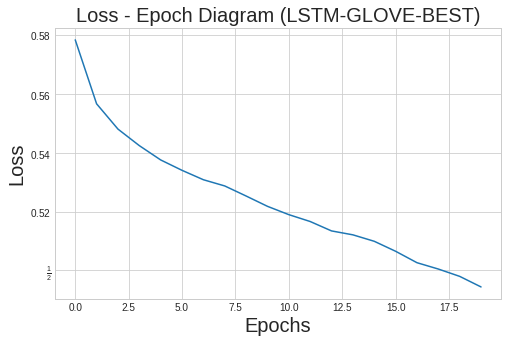

In [57]:
loss_per_epoch(glove_ls, 'LSTM-GLOVE-BEST')

### ROC Curve

**The Auc Score of LSTM-GLOVE-BEST Neural Network, using pre-trained glove embeddings input vectors is ~80% and it's a decent score. As a matter of fact, the Auc Score is almost the same for all the models we experimented with. The high Auc Score means that the model has a good ability at measuring how often a sentiment rating is correct. We should be happy with our result, specially if we consider that Recurrent Neural Networks is a class of Neural Networks that are helpful in modeling sequencial data and they are not so effective at extracting local and position-invariant features. For tasks like Sentiment Analysis, where feature detection in text is more important (searching for angry terms, irony, sadness etc.), a Convolution Neural Network would produce the best results possible. <br> The Auc Score is visualized in the below ROC diagram, where the outcome is almost a perfect curve.**

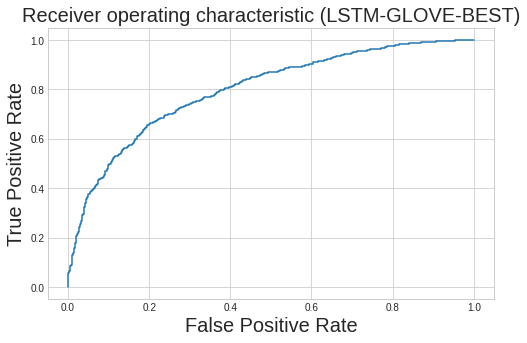


ROC Score =  79.698%


In [58]:
# display the best ROC diagram based on Auc Score
roc_plot(best_net, test_glove, test_y, batch, 'LSTM-GLOVE-BEST')

### Recurrent Neural Network vs Feed-Forward Neural Network

In [59]:
# initialize dataframe to display loss results 
ls_dic = {'FFNN-GLOVE':['-'], 'LSTM-GLOVE-BEST':['-']}
ls_df = pd.DataFrame.from_dict(ls_dic, orient='index', columns=['Final-loss'])

ls_df.loc['FFNN-GLOVE', 'Final-loss'] = '0.518319'
ls_df.loc['LSTM-GLOVE-BEST', 'Final-loss'] = glove_ls[-1]
ls_df

,Final-loss
FFNN-GLOVE,0.518319
LSTM-GLOVE-BEST,0.49417


**We observe that both Neural Networks produce better results when using pre-trained glove embeddings input vectors. Firstly, we compare our best Recurrent Neural Network with our best Feed-Forward Neural Network of our first notebook, based on the loss convergence. We train our best models with 20 epochs in both cases and we notice that our bidirectional 2 stacked RNN model, using LSTM cells is converging faster than our best Feed-Forward Neural Network. That's a logical outcome, because as we mentioned earlier LSTMs are consisted of memory cells that are able to maintain information in memory for long periods of time.
On the other hand, Feed-Foward Neural Networks are primarily used in cases where the data to be learned is neither sequential nor time-dependent. As a result, in a Sentiment Classification problem like ours, which is composed of plenty long-term temporal dependencies we expect our RNN to learn the data faster.**

In [60]:
# initialize dataframe to display metrics results 
sc_dic = {'FFNN-GLOVE':['-', '-', '-'], 'LSTM-GLOVE-BEST':['-', '-', '-']}
sc_df = pd.DataFrame.from_dict(sc_dic, orient='index', columns=['Precision', 'Recall', 'F1-Score'])

sc_df.loc['FFNN-GLOVE','Precision'] = '73.868%'
sc_df.loc['FFNN-GLOVE','Recall'] = '73.475%'
sc_df.loc['FFNN-GLOVE','F1-Score'] = '73.671%'

sc_df.loc['LSTM-GLOVE-BEST','Precision'] = best_df.loc['LSTM-GLOVE-BEST','Precision']
sc_df.loc['LSTM-GLOVE-BEST','Recall'] = best_df.loc['LSTM-GLOVE-BEST','Recall']
sc_df.loc['LSTM-GLOVE-BEST','F1-Score'] = best_df.loc['LSTM-GLOVE-BEST','F1-Score']

sc_df 

,Precision,Recall,F1-Score
FFNN-GLOVE,73.868%,73.475%,73.671%
LSTM-GLOVE-BEST,71.716%,71.919%,71.806%


**Subsequently, we compare our best models, based on the metrics of the prediction on the test set. Both models seem to produce very similar metrics with our FFNN being slightly more effective than our RNN, assuming that the F1-Score is a descent representative for a model's effeciency. Even though the metrics difference is not significant we can notice that the LSTM's ability on maintaining information leads to a faster convergence but not to better classification results. Yet, as we mentioned the metrics difference is insignificant. As a result, the noticeable faster convergence of RNN (RNN model converges even faster than FFNN if we train them with more epochs) is an important factor that can lead to its supremacy compared to FFNN. Either way, neither Recurrent Neural Networks nor Feed-Forward Neural Networks are the ideal to be applied in feature detection in texts. As we know, in theory, for tasks like Sentiment Analysis, where feature detection in text is more important (searching for angry terms, irony, sadness etc.), a Convolution Neural Network would surely produce better results.**